<a href="https://colab.research.google.com/github/S-Delowar/PlantVision-TF-TL/blob/main/plant_vision_with_tensorflow_and_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9c0ec94d-e9cd-abf8-459d-753432514ac9)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define some utility functions

In [3]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Training History"):
    """
    Plots training and validation accuracy/loss from a history object.

    Args:
    - history: A TensorFlow History object from model.fit()
    - title: Title for the plot
    """
    acc = history.history.get("accuracy")
    val_acc = history.history.get("val_accuracy")
    loss = history.history.get("loss")
    val_loss = history.history.get("val_loss")

    epochs = range(len(acc))

    plt.figure(figsize=(14, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Training Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Download Data

We are going to use Oxford_Flower_102 dataset from TensorFlowDataset (TFDS)

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [5]:
# List all available datasets and check oxford_flower101 is there or not
dataset_list = tfds.list_builders()
print("oxford_flowers102" in dataset_list)

True


In [ ]:
# Load the Data and Related Info
(test_data, train_data, validation_data), ds_info = tfds.load(name="oxford_flowers102",
                                             split=["test", "train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

# Explore Oxford_Flower_102 data
In the dataset, there are 3 sets - training (1000 images), validation (1000 images) and test set (6000 images) almost.

Exploring some necessary informations about the data-
- Class names
- Shape of our input data (image tensors)
- Datatype of our input data
- Labels (one-hot-encoded or label-encoded?)
- Do the labels match with class names

In [7]:
# Features of our dataset from TFDS
ds_info.features

FeaturesDict({
    'file_name': Text(shape=(), dtype=string),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=102),
})

In [8]:
# Get the class names
class_names = ds_info.features["label"].names
len(class_names), class_names

(102,
 ['pink primrose',
  'hard-leaved pocket orchid',
  'canterbury bells',
  'sweet pea',
  'english marigold',
  'tiger lily',
  'moon orchid',
  'bird of paradise',
  'monkshood',
  'globe thistle',
  'snapdragon',
  "colt's foot",
  'king protea',
  'spear thistle',
  'yellow iris',
  'globe-flower',
  'purple coneflower',
  'peruvian lily',
  'balloon flower',
  'giant white arum lily',
  'fire lily',
  'pincushion flower',
  'fritillary',
  'red ginger',
  'grape hyacinth',
  'corn poppy',
  'prince of wales feathers',
  'stemless gentian',
  'artichoke',
  'sweet william',
  'carnation',
  'garden phlox',
  'love in the mist',
  'mexican aster',
  'alpine sea holly',
  'ruby-lipped cattleya',
  'cape flower',
  'great masterwort',
  'siam tulip',
  'lenten rose',
  'barbeton daisy',
  'daffodil',
  'sword lily',
  'poinsettia',
  'bolero deep blue',
  'wallflower',
  'marigold',
  'buttercup',
  'oxeye daisy',
  'common dandelion',
  'petunia',
  'wild pansy',
  'primula',
  '

In [9]:
train_data, validation_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [10]:
# Take one sample of the train data
train_one_sample = train_data.take(1)

# Output info about the sample
for image, label in train_one_sample:
  print(f"""
    Image shape: {image.shape},
    Image datatype: {image.dtype},
    Target class from Food101: {label},
    Class name: {class_names[label.numpy()]}
  """)


    Image shape: (500, 667, 3),
    Image datatype: <dtype: 'uint8'>,
    Target class from Food101: 72,
    Class name: water lily
  


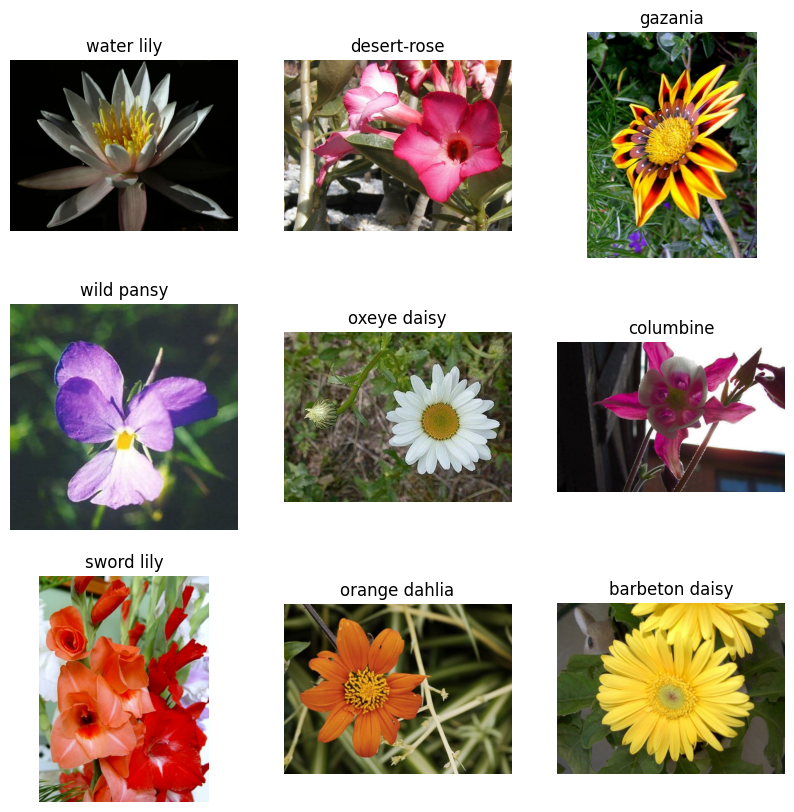

In [13]:
# display some training images
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_data.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label.numpy()])
    plt.axis("off")

In [14]:
# Maximum and Minimum values of our image tensor
tf.reduce_max(image), tf.reduce_min(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=255>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=0>)

# Create Preprocessing Functions for our Data

What we know about our data-
- In unit8 dtype
- Different size/tensors
- Not scaled (values are from 0 to 255)

What we know models for better performance/pre-trained models like-
- In float32 or mixed-precision (mixed of float16 and float32)
- For a batch, images are same in size
- Scaled/Normalized( 0 to 1) [Some pre-trained models has own scaling layer, thus they do not need pre-scaling data]

Therefore, our preprocessing function needs to-
- Convert dtype from unit8 to float32 or mixed-precision
- Reshape all images to same size
- Rescaling (if our model needs, EfficientNetX does not need)

In [15]:
# Creating Preprocessing Function
def preprocess_image(image, label, image_shape=300):
  """
    Converts image datatype from 'uint8' to 'float32' and reshapes image to [image_shape, image_shape, color_channels]
  """
  image = tf.image.resize(image, size=[image_shape, image_shape])
  # image = image / 255.  # Not needed for EfficientNetBX
  return tf.cast(image, tf.float32), label

In [16]:
# Preprocess a single sample image and check otputs
print(f"Before Preprocessing:\n  Shape: {image.shape}, Datatype: {image.dtype}")

preprocessed_image = preprocess_image(image, label)[0]
print(f"After Preprocessing:\n  Shape: {preprocessed_image.shape}, Datatype: {preprocessed_image.dtype}")

Before Preprocessing:
  Shape: (500, 667, 3), Datatype: <dtype: 'uint8'>
After Preprocessing:
  Shape: (300, 300, 3), Datatype: <dtype: 'float32'>


# Prepare Datasets with AUTOTUNE, Batch, Prefetch

In [17]:
# Map preprocessing function to train data (and Parallelize)
train_data = train_data.map(
    map_func = preprocess_image,
    num_parallel_calls =tf.data.AUTOTUNE
)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to the test data
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

validation_data = validation_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [18]:
train_data, test_data, validation_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Create Modelling Callbacks

- TensorBoard callback to log and visulize training results
- ModelCheckpoint callback to save our model's progress after feature extraction
- EarlyStop callback if more epochs

In [19]:
# Create TensorBoard Callback function
import datetime

def create_tensorboard_callback(experiment_name, dir_name="/content/drive/MyDrive/TensorFlow_Projects/PlantVision_Project/training_logs"):
  """Create TensorBoard Callback"""

  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [20]:
# Create ModelCheckpoint callback

def create_model_checkpoint_callback(checkpoint_filename, dir_name="/content/drive/MyDrive/TensorFlow_Projects/PlantVision_Project/model_checkpoints"):
  """
    Saving Model Checkpoint
  """
  checkpoint_path = dir_name + "/" + checkpoint_filename
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    mode = "max",
    verbose=1)
  return model_checkpoint

In [21]:
# Create EarlyStopping Callback
earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Set Mixed-Precision Training

In [22]:
from tensorflow.keras import mixed_precision
mixed_precision.global_policy()

<DTypePolicy "float32">

In [23]:
mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

# Build Feature Extraction Model

Steps to build our feature extraction model-
- Create Data Augmentation layer
- Initiate a base pre-trained model
- Freeze the whole base model
- Define other layers and build the model
- Compile the model
- Fit the Model to extract features

In [24]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomHeight, RandomWidth, RandomZoom, Rescaling
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2),
  RandomHeight(0.2),
  RandomWidth(0.2),
  RandomZoom(0.2),
  # Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

In [25]:
# setup base model
base_model = tf.keras.applications.EfficientNetB3(
    include_top = False,
    input_shape = (300, 300, 3),
    weights = "imagenet"
)
# Freeze the base model
base_model.trainable = False

# Add new layers on Top
inputs = layers.Input(shape=(300, 300,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) #Ensure inference mode
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32_output_layer")(x)

model = tf.keras.Model(inputs, outputs)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, None, None,     │    10,783,535 │
│                                 │ 1536)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool_layer           │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 102)            │       156,774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_2 (Cast)                   │ (None, 102)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32_output_layer    │ (None, 102)            │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,940,309 (41.73 MB)

 Trainable params: 156,774 (612.40 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [27]:
# Check layer type  and type_policy
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
data_augmentation True float32 <DTypePolicy "mixed_float16">
efficientnetb3 False float32 <DTypePolicy "mixed_float16">
global_avg_pool_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32_output_layer True float32 <DTypePolicy "float32">


In [28]:
# Compile the feature extractor model
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy", SparseTopKCategoricalAccuracy(k=5)]
)

In [29]:
# Fit the feature extractor Model
history_feature_extractor = model.fit(
    train_data,
    epochs = 10,
    validation_data = validation_data,
    callbacks = [
        create_tensorboard_callback(experiment_name="efficientnetb3_feature_extraction"),
        create_model_checkpoint_callback("best_feature_extractor_model.keras"),
        earlystopping_cb
        ]
)

Saving TensorBoard log files to: /content/drive/MyDrive/TensorFlow_Projects/PlantVision_Project/training_logs/efficientnetb3_feature_extraction/20250424-102522
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.0713 - loss: 4.5559 - sparse_top_k_categorical_accuracy: 0.1604
Epoch 1: val_accuracy improved from -inf to 0.38431, saving model to /content/drive/MyDrive/TensorFlow_Projects/PlantVision_Project/model_checkpoints/best_feature_extractor_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 842ms/step - accuracy: 0.0726 - loss: 4.5479 - sparse_top_k_categorical_accuracy: 0.1643 - val_accuracy: 0.3843 - val_loss: 3.5144 - val_sparse_top_k_categorical_accuracy: 0.6725
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.5538 - loss: 3.1119 - sparse_top_k_categorical_accuracy: 0.8101
Epoch 2: val_accuracy improved from 0.38431 to 0.58725, saving model to /content/drive/MyDrive/TensorFlow_Projects/PlantVision_Project/model_checkpoints/best_feature_extractor_model.ker

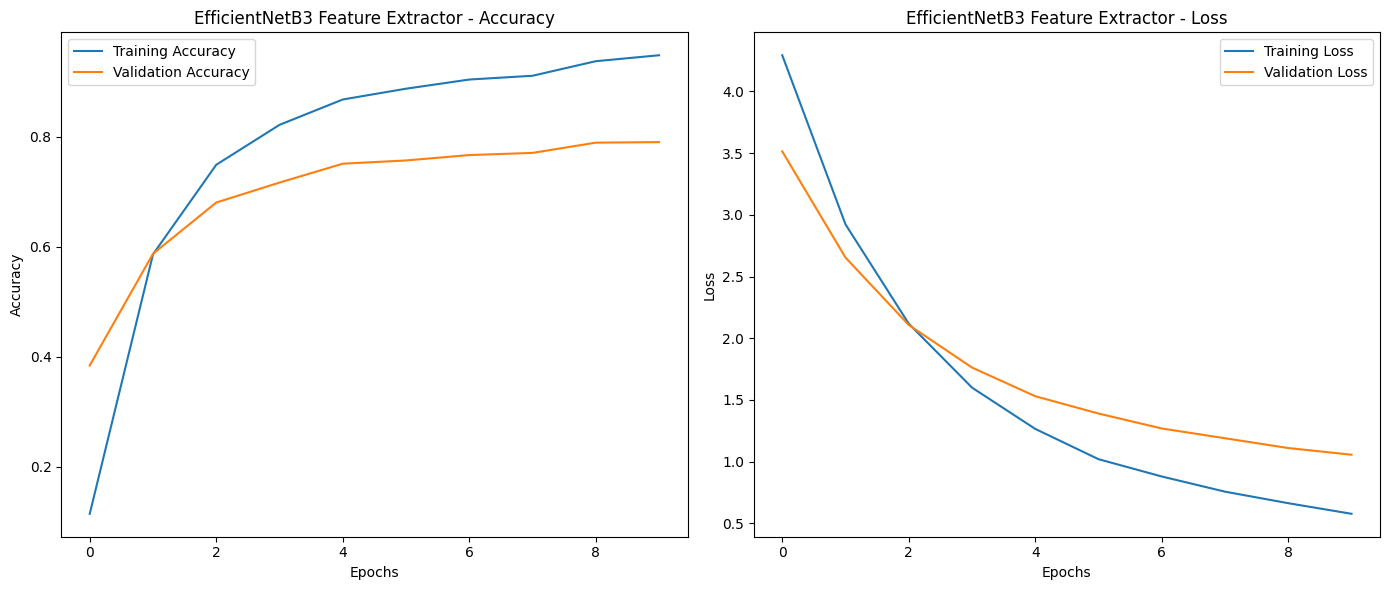

In [30]:
plot_training_history(history_feature_extractor, title="EfficientNetB3 Feature Extractor")

##### Evaluating Feature Extractor on whole Test Data

In [31]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

193/193 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step - accuracy: 0.7693 - loss: 1.1327 - sparse_top_k_categorical_accuracy: 0.9323


[1.1196295022964478, 0.7716701626777649, 0.9328346252441406]

#### Observation on Feature Extractor Model

- Feature Extractor performs very well on teaining data. Both top-1 and top-5 accuracy are good to go (more than 90%).
- Validation accuracy 79.02% and Evaluating on test data gives us accuracy 76.93%
- Fine Tunining needed to improvement of accuracy on validation and test data

# Fine Tuning

In [32]:
# Check some layers of base_model.layers in our model
for layer in base_model.layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer False float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16"

In [33]:
# Check number os layers in the base model
len(base_model.layers)

385

In [34]:
# Unfreeze all the layers of the base model
base_model.trainable = True

# Refreeze every layer except the last 30
for layer in base_model.layers[:-30]:
  layer.trainable = False

In [35]:
# Recompile the model with lower learning rate
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-6),
    metrics=["accuracy", SparseTopKCategoricalAccuracy(k=5)]
)

In [36]:
# Fit the model now for 5 epochs
history_model_fine_tuned = model.fit(
    train_data,
    epochs = 5,
    validation_data = validation_data,
    callbacks = [
        create_tensorboard_callback(experiment_name="efficientnetb3_fine_tuning"),
        create_model_checkpoint_callback("best_102_flowes_model_fine_tuned.keras"),
        ]
)

Saving TensorBoard log files to: /content/drive/MyDrive/TensorFlow_Projects/PlantVision_Project/training_logs/efficientnetb3_fine_tuning/20250424-103828
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7791 - loss: 1.6801 - sparse_top_k_categorical_accuracy: 0.9320
Epoch 1: val_accuracy improved from -inf to 0.79510, saving model to /content/drive/MyDrive/TensorFlow_Projects/PlantVision_Project/model_checkpoints/best_102_flowes_model_fine_tuned.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7781 - loss: 1.6816 - sparse_top_k_categorical_accuracy: 0.9317 - val_accuracy: 0.7951 - val_loss: 1.0562 - val_sparse_top_k_categorical_accuracy: 0.9363
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.7414 - loss: 1.7271 - sparse_top_k_categorical_accuracy: 0.9084
Epoch 2: val_accuracy did not improve from 0.79510
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 597ms/step - accuracy: 0.7415 - loss: 1.7271 - sparse_top_k_categorical_accuracy: 0.9087 - val_accuracy: 0.7647

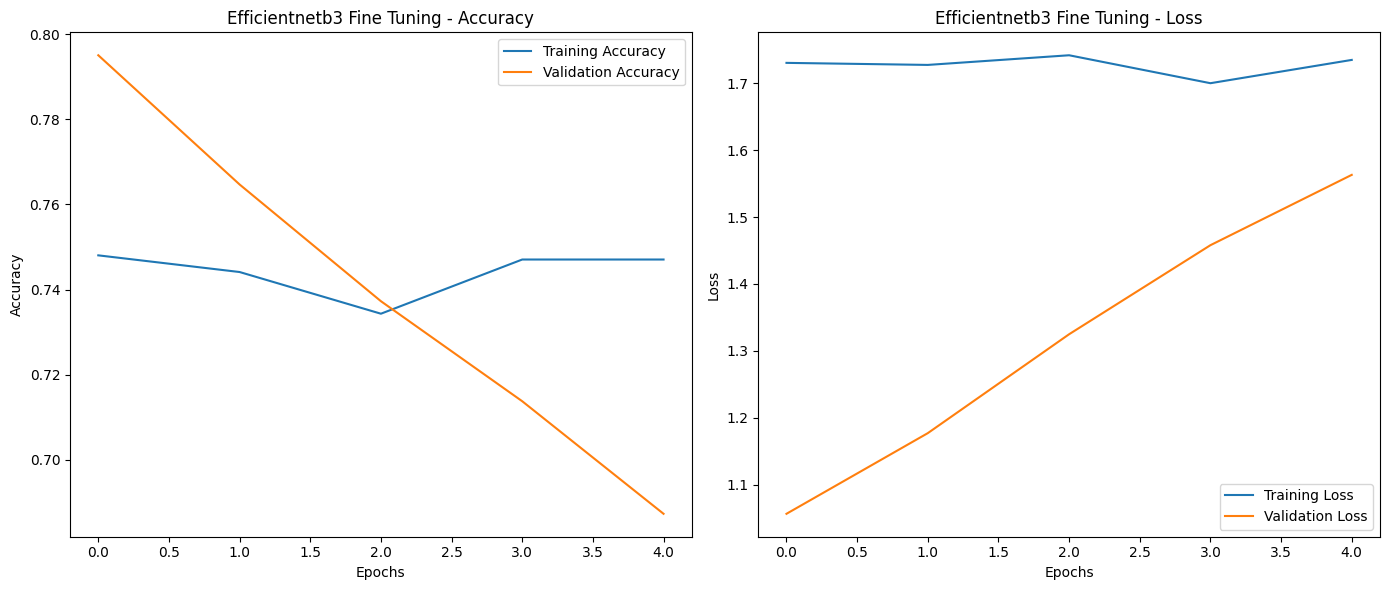

In [37]:
# Fine tuned results history
plot_training_history(history_model_fine_tuned, title="Efficientnetb3 Fine Tuning")


In [38]:
# Evaluate fine tuned model on whole test dataset
results_fine_tuned_model = model.evaluate(test_data)
results_fine_tuned_model

193/193 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - accuracy: 0.6286 - loss: 1.7467 - sparse_top_k_categorical_accuracy: 0.8526


[1.7350367307662964, 0.6376646757125854, 0.8606277704238892]

#### Observation on Fine Tuning

- this time, there is a significant fall in training accuracy (from 94% to 74%)
- validation accuracy also decresed to 68.73% which is lower than previous value.
- validation loss has stable increment
- Evaluation accuracy on test data also decreased by near to 14%

So, our fine tuning is not good.

Lets fine tune  the feature extractor again...


# Re Fine Tuning


This time we will -
- Unfreeze less number of layer from base model
- add droupout layer before dense layer for regularization
And then see what's happening.

In [39]:
# Load the saved feature exteactor as it was good in performance
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/TensorFlow_Projects/PlantVision_Project/model_checkpoints/best_feature_extractor_model.keras",
)

In [40]:
model.layers, model.input

([<InputLayer name=input_layer, built=True>,
  <Sequential name=data_augmentation, built=True>,
  <Functional name=efficientnetb3, built=True>,
  <GlobalAveragePooling2D name=global_avg_pool_layer, built=True>,
  <Dense name=dense, built=True>,
  <Activation name=softmax_float32_output_layer, built=True>],
 <KerasTensor shape=(None, 300, 300, 3), dtype=float32, sparse=False, name=input_layer>)

In [41]:
# the base_model
model.layers[2], model.layers[2].trainable

(<Functional name=efficientnetb3, built=True>, False)

In [42]:
# Unfreeze the last 10 layers of EfficientNetB3
for layer in model.layers[2].layers[-10:]:
  layer.trainable = True

In [43]:
# Check some last layers of base model where last 10 layers will be trainable now
for layer in model.layers[2].layers[-20:]:
  print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True


In [44]:
# Add Dropout before the final layer
x = model.layers[-3].output  # Get the layer before the final Dense layer
x = tf.keras.layers.Dropout(0.2)(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32_output_layer")(x)

model = tf.keras.Model(inputs=model.input, outputs=outputs)

# Recompile with learning rate (1e-3) as very lower value (1e-6) perfomed worst in first fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", SparseTopKCategoricalAccuracy(k=5)]
)

In [45]:
# Fit the new model now for 10 epochs
history_model_fine_tuned_2 = model.fit(
    train_data,
    epochs = 10,
    validation_data = validation_data,
    callbacks = [
        create_tensorboard_callback(experiment_name="efficientnetb3r_fine_tuning_2"),
        create_model_checkpoint_callback("best_102_flowes_model_fine_tuned_2.keras"),
        earlystopping_cb
        ]
)

Saving TensorBoard log files to: /content/drive/MyDrive/TensorFlow_Projects/PlantVision_Project/training_logs/efficientnetb3r_fine_tuning_2/20250424-105643
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.1593 - loss: 4.1293 - sparse_top_k_categorical_accuracy: 0.2960
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to /content/drive/MyDrive/TensorFlow_Projects/PlantVision_Project/model_checkpoints/best_102_flowes_model_fine_tuned_2.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 806ms/step - accuracy: 0.1628 - loss: 4.1123 - sparse_top_k_categorical_accuracy: 0.3018 - val_accuracy: 0.6000 - val_loss: 1.8636 - val_sparse_top_k_categorical_accuracy: 0.8225
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7263 - loss: 1.5876 - sparse_top_k_categorical_accuracy: 0.9401
Epoch 2: val_accuracy improved from 0.60000 to 0.75980, saving model to /content/drive/MyDrive/TensorFlow_Projects/PlantVision_Project/model_checkpoints/best_102_flowes_model_fine_tun

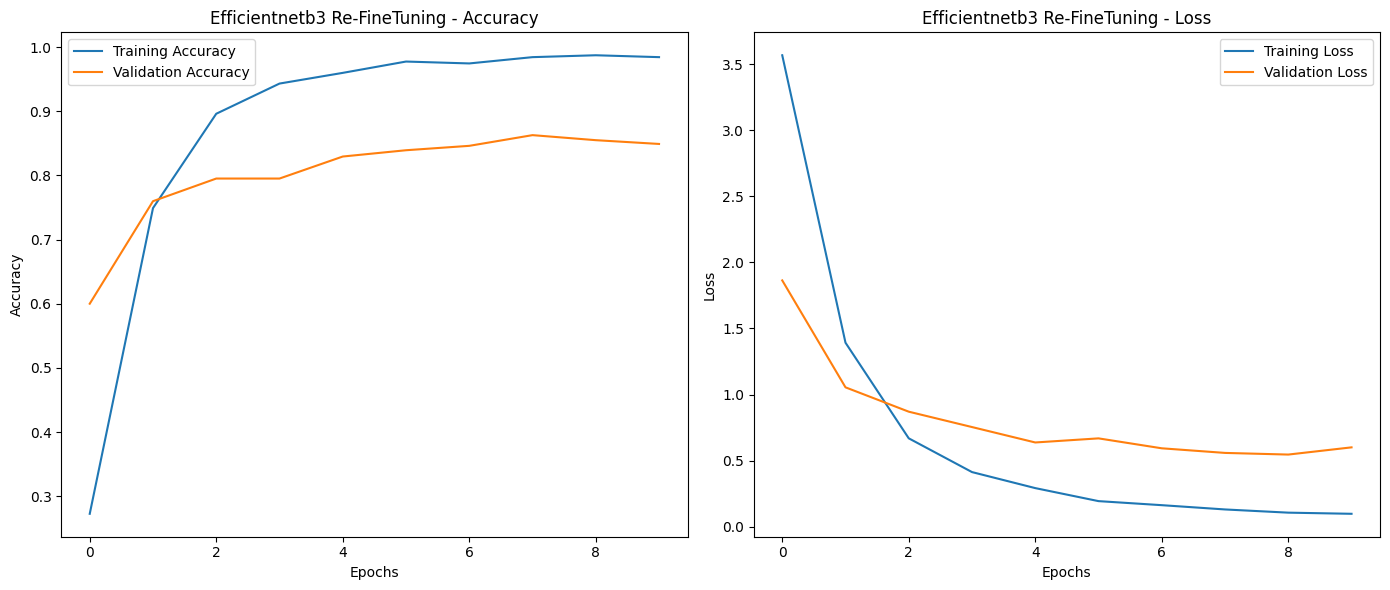

In [46]:
plot_training_history(history_model_fine_tuned_2, title="Efficientnetb3 Re-FineTuning")

In [47]:
# Evaluate on whole test data
model.evaluate(test_data)

193/193 ━━━━━━━━━━━━━━━━━━━━ 37s 193ms/step - accuracy: 0.8346 - loss: 0.6141 - sparse_top_k_categorical_accuracy: 0.9615


[0.607203483581543, 0.835745632648468, 0.9611318707466125]

#### Observation from re- fine tuning

- this time, both training and validation accuracy significantly increased (98% and 84.9%)
- validation loss also has notable decrease
- evaluation accuracy on whole test data also increased to 83.4%

So, we can go with this model..

# Load and Check the Saved best fine tuned Model

In [48]:
# Load the saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/TensorFlow_Projects/PlantVision_Project/model_checkpoints/best_102_flowes_model_fine_tuned_2.keras")
loaded_model.evaluate(test_data)

193/193 ━━━━━━━━━━━━━━━━━━━━ 46s 191ms/step - accuracy: 0.8377 - loss: 0.6403 - sparse_top_k_categorical_accuracy: 0.9617


[0.6297293305397034, 0.8347699046134949, 0.9621076583862305]

# Model's Prediction and Visualization on Test Data

In [49]:
# Function to make and visualize predictions
def visualize_predictions(test_data, model, num_examples=3):
    plt.figure(figsize=(17, 10))

    # Take a batch from test data
    test_batch = next(iter(test_data.unbatch().batch(num_examples)))

    for i, (image, true_label) in enumerate(zip(test_batch[0], test_batch[1])):
        # Make prediction
        pred_prob = model.predict(tf.expand_dims(image, axis=0))
        pred_class_idx = pred_prob.argmax()
        pred_class = class_names[pred_class_idx]
        true_class = class_names[true_label.numpy()]
        confidence = pred_prob.max()

        # Plot
        plt.subplot(1, num_examples, i+1)
        plt.imshow(image.numpy().astype('uint8'))
        title_color = "g" if true_class == pred_class else "r"
        plt.title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}",
                 color=title_color, fontsize=12)
        plt.axis(False)

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


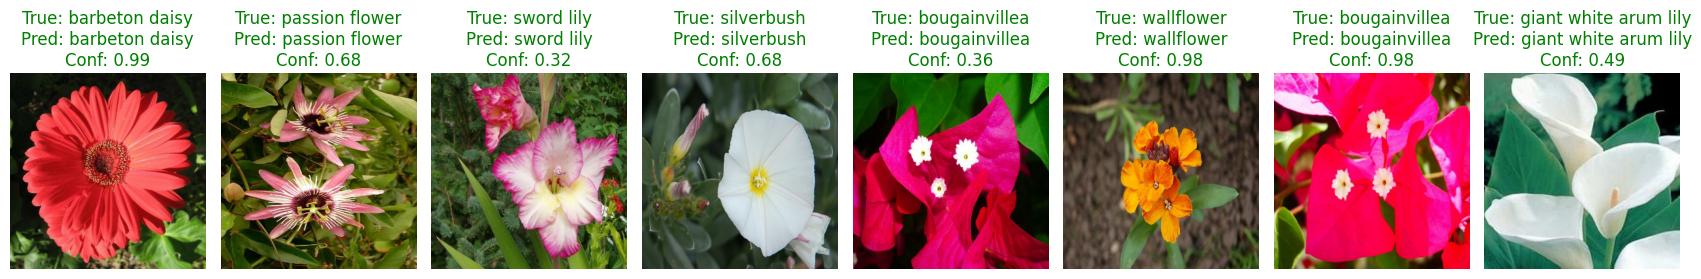

In [53]:
# Visualize prediction on 5 test data
visualize_predictions(test_data, loaded_model, num_examples=8)

# Make Prediction on Custom Data

In [57]:
import numpy as np

def load_prep_and_predict(image_path, model, class_names, image_size=(300, 300)):
  """
    Loading, Preprocesing and Making Prediction
  """
  # Load and preprocess the image (matching your training pipeline)
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, image_size)

  # Apply EfficientNet preprocessing if needed
  # img = tf.keras.applications.efficientnet.preprocess_input(img)

  # Make prediction
  img_batch = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_batch)
  pred_class = class_names[np.argmax(pred_prob)]
  confidence = np.max(pred_prob)

  return img, pred_class, confidence

In [58]:
def show_predicted_img(img, pred_class, confidence):
  """
    Ploting custom image with prediction class and confidence
  """
  plt.imshow(img/255.)  # Scale for display
  plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2%}", fontsize=16)
  plt.axis('off')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


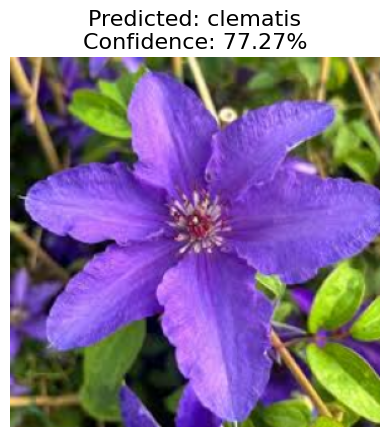

In [59]:
# Visualize prediction on single custom image
img, pred_class, confidence = load_prep_and_predict("/content/drive/MyDrive/TensorFlow_Projects/PlantVision_Project/custom_images/clematis1.jpeg", loaded_model, class_names)
show_predicted_img(img, pred_class, confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


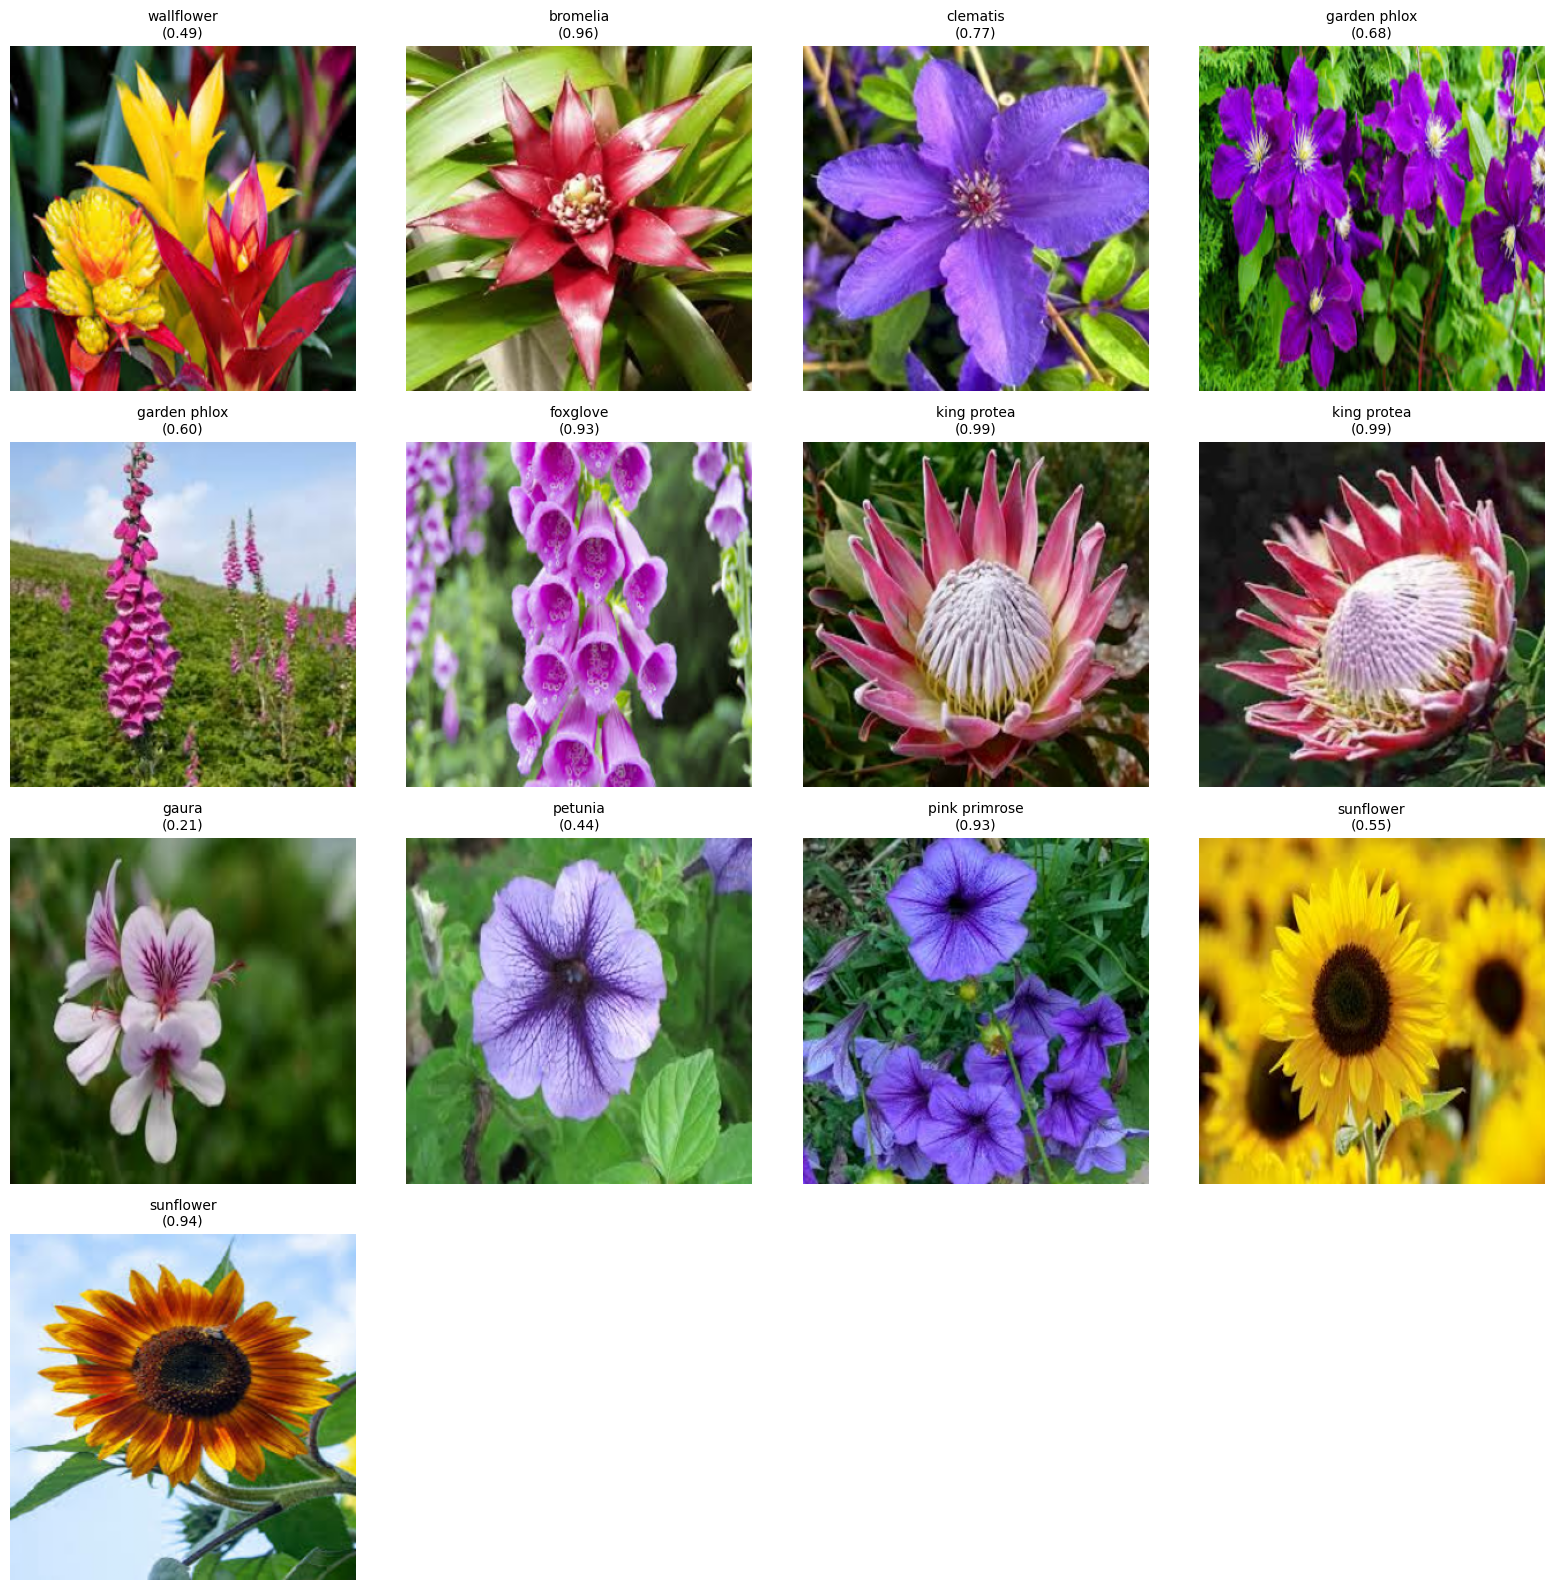

In [60]:
# Prediction on multiple custom images

import os
import math

image_folder = '/content/drive/MyDrive/TensorFlow_Projects/PlantVision_Project/custom_images'
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))])
num_images = len(image_files)


# Create a figure with appropriate layout
cols = 4
rows = math.ceil(num_images / cols)
plt.figure(figsize=(cols * 4, rows * 4))

for i, img_file in enumerate(image_files, 1):
    img_path = os.path.join(image_folder, img_file)

    # Load and preprocess the image
    img, pred_class, confidence = load_prep_and_predict(img_path, loaded_model, class_names)

    # Plot the image with prediction
    plt.subplot(rows, cols, i)
    img = img / 255
    plt.imshow(img)
    plt.title(f"{pred_class}\n({confidence:.2f})", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()